# Final Project: Module 6 – Regression Analysis

**Name:** Lindsay Foster 

**Date:** 11/23/2025

# Introduction
In this project, I use regression analysis to examine how different factors contribute to insurance charges. Using the Medical Cost dataset, I explore the data, select meaningful features, and build predictive models based on variables such as age, BMI, and smoking status. The goal is to compare regression methods and evaluate how well they predict medical insurance costs.

## Imports

In [118]:
# ------------------------------------------------
# Imports once at the top, organized
# ------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

## Import and Inspect the Data

In [74]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/insurance.csv")

# Display the first 10 rows
df.head(10)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [75]:
# Check for missing values
df.isnull().sum()
df[df.isnull().any(axis=1)]
# There are no missing values in the dataset

,age,sex,bmi,children,smoker,region,charges


In [76]:
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Reflection 1: What do you notice about the dataset? Are there any data issues?
There are no missing values and the data is easy to read. 

## Data Exploration and Preparation

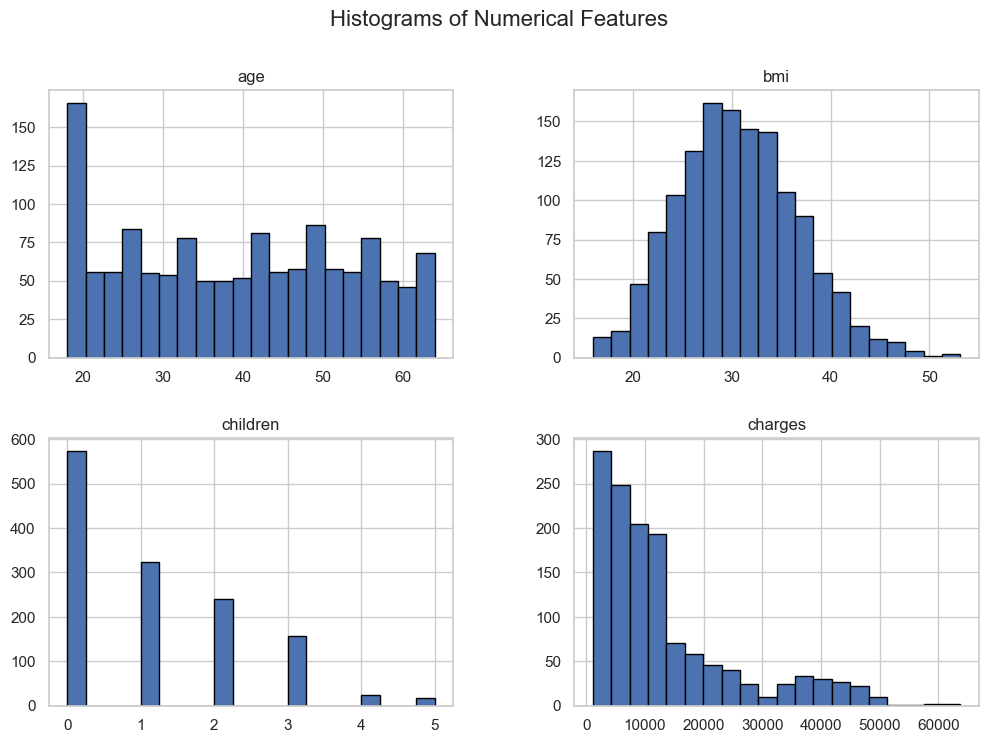

In [77]:
# Histograms for Numerical Features

# Set style
sns.set(style="whitegrid")

# Histograms
df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()


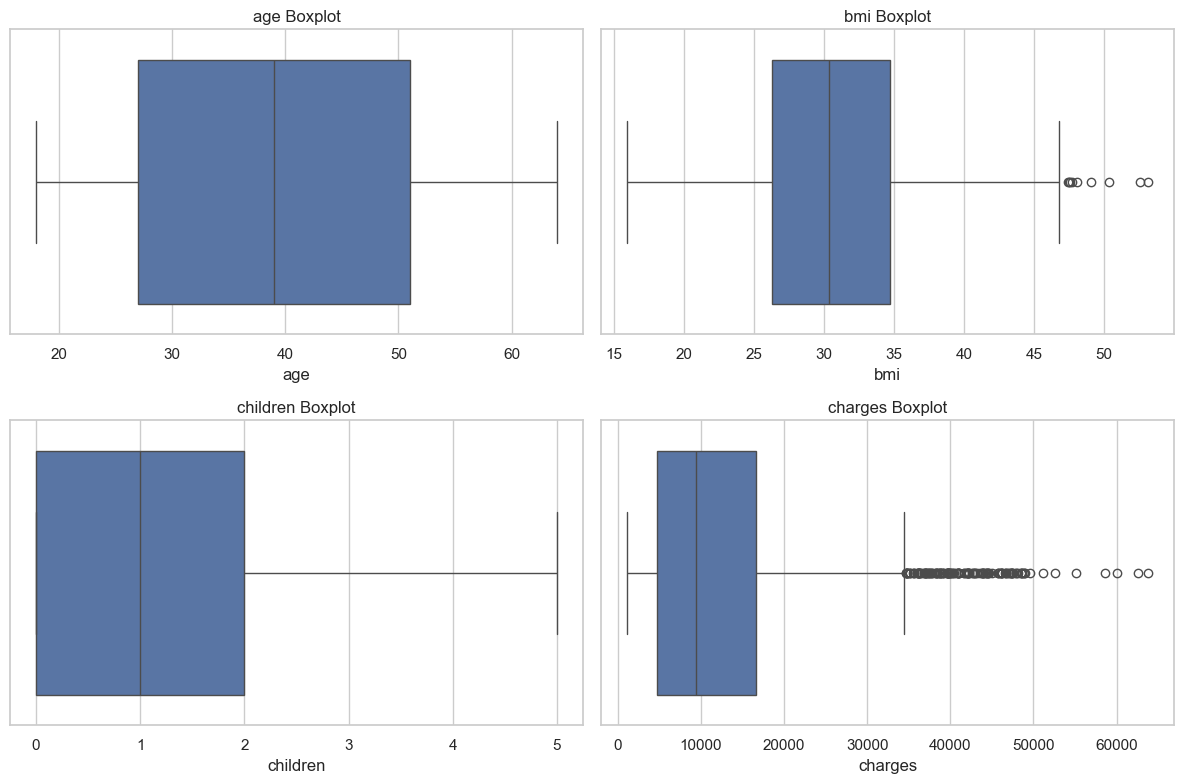

In [78]:
# Boxplots for Numerical Features

plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'bmi', 'children', 'charges'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"{col} Boxplot")

plt.tight_layout()
plt.show()


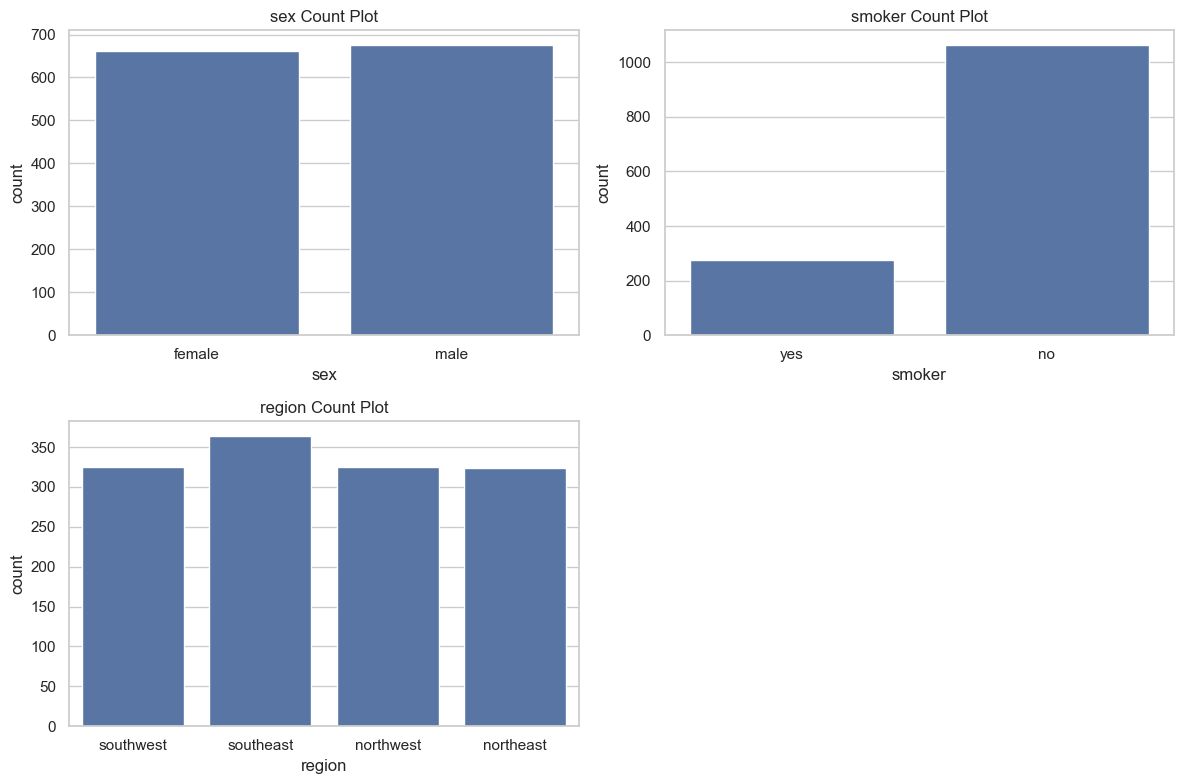

In [79]:
# Count Plots for Categorical Features

categorical_cols = ['sex', 'smoker', 'region']

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col)
    plt.title(f"{col} Count Plot")

plt.tight_layout()
plt.show()


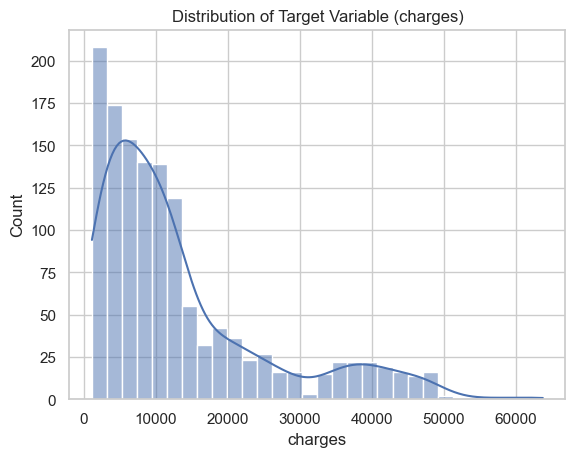

In [80]:
sns.histplot(df['charges'], kde=True)
plt.title("Distribution of Target Variable (charges)")
plt.show()


In [81]:
# Outlier Detection and Removal using IQR method

df_clean = df.copy()

for col in ['bmi', 'charges']:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

df_clean.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [82]:
# Encoding Categorical Variables

df_encoded = pd.get_dummies(df_clean, drop_first=True)
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [83]:
# Creating BMI Categories

df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])
df = pd.get_dummies(df, columns=['bmi_category'], drop_first=True)


In [84]:
# Create a copy for plotting
df['bmi_category_vis'] = pd.cut(
    df['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)


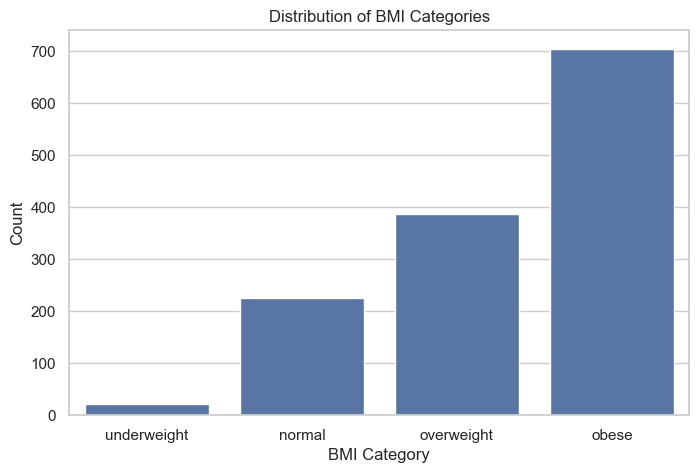

In [85]:
# Plot BMI Categories

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bmi_category_vis', order=['underweight', 'normal', 'overweight', 'obese'])
plt.title("Distribution of BMI Categories")
plt.xlabel("BMI Category")
plt.ylabel("Count")
plt.show()


In [86]:
# Feature Scaling

scaler = StandardScaler()
numeric_cols = ['age', 'bmi', 'children', 'charges']

df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.424190,-0.356784,-0.894220,0.972086,False,True,False,False,True
1,-1.495361,0.643537,-0.071814,-1.137965,True,False,False,True,False
2,-0.783654,0.512320,1.572998,-0.758821,True,False,False,True,False
3,-0.427801,-1.242076,-0.894220,1.681898,True,False,True,False,False
4,-0.498972,-0.189779,-0.894220,-0.839914,True,False,True,False,False


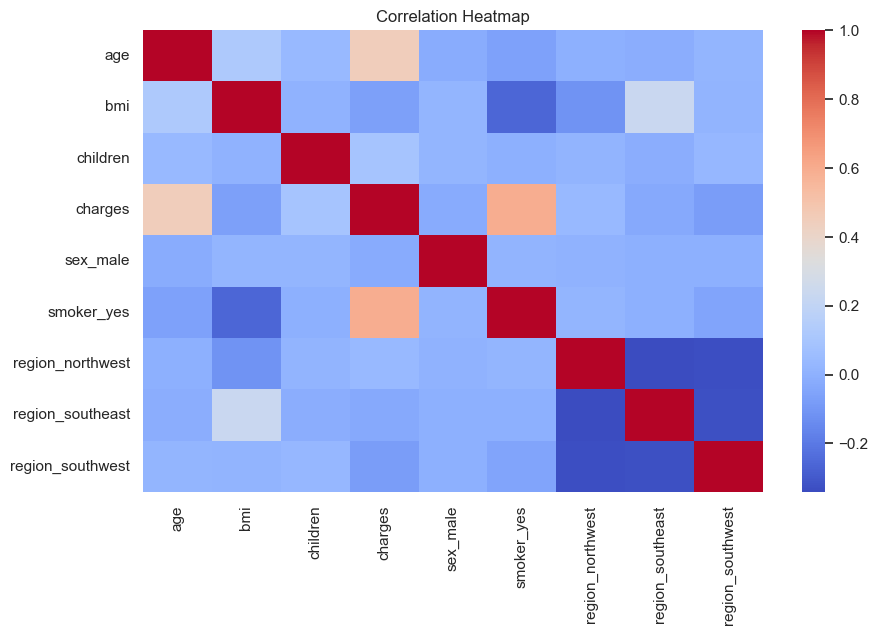

In [87]:
# Correlation Heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


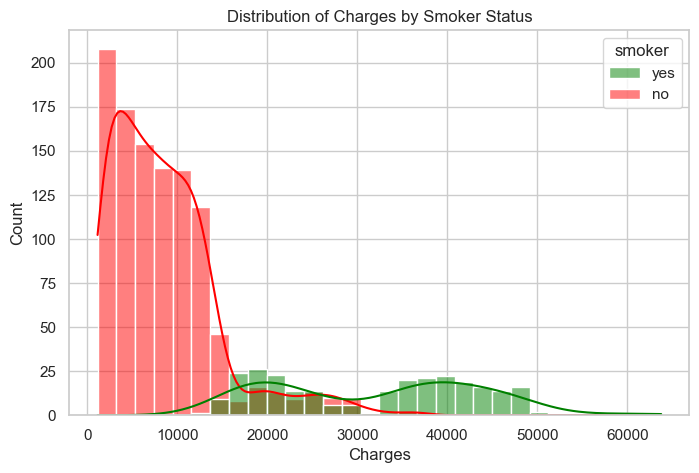

In [88]:
# Charges by Smoker Status

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='charges', hue='smoker', kde=True, bins=30, palette=['green','red'])
plt.title("Distribution of Charges by Smoker Status")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.show()

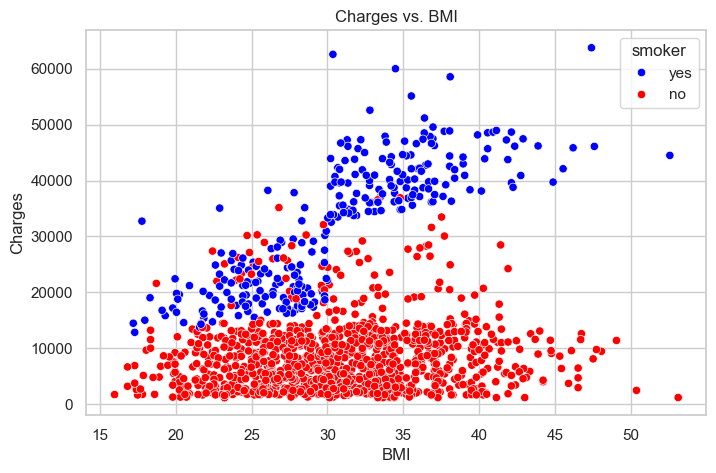

In [89]:
# Charges vs. BMI

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', palette=['blue','red'])
plt.title("Charges vs. BMI")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

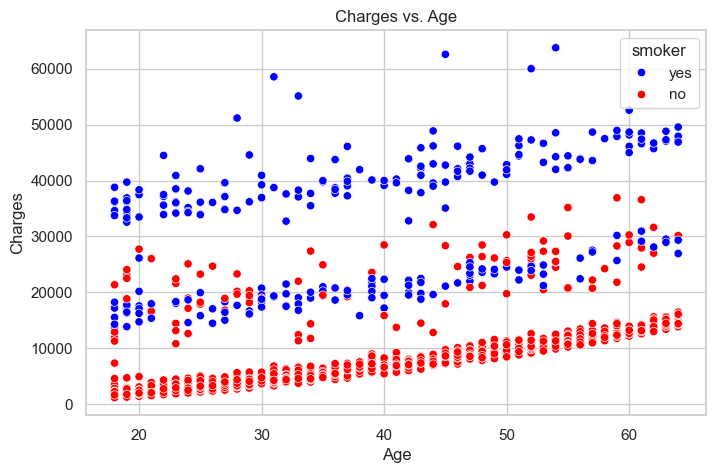

In [90]:
# Charges vs Age

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', palette=['blue','red'])
plt.title("Charges vs. Age")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

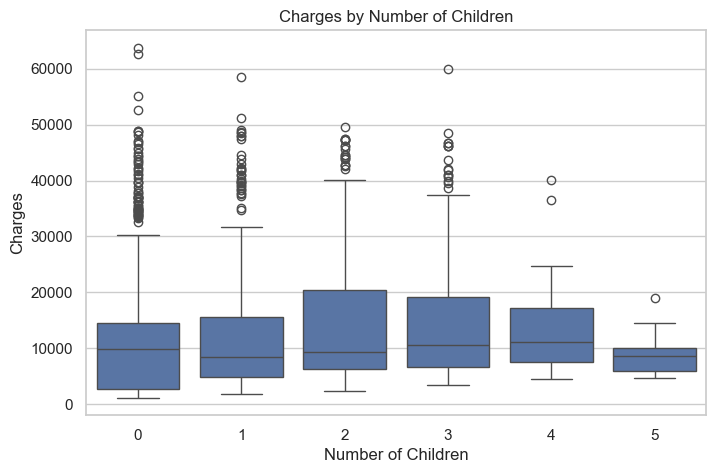

In [91]:
# Charges vs Children

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='children', y='charges')
plt.title("Charges by Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()

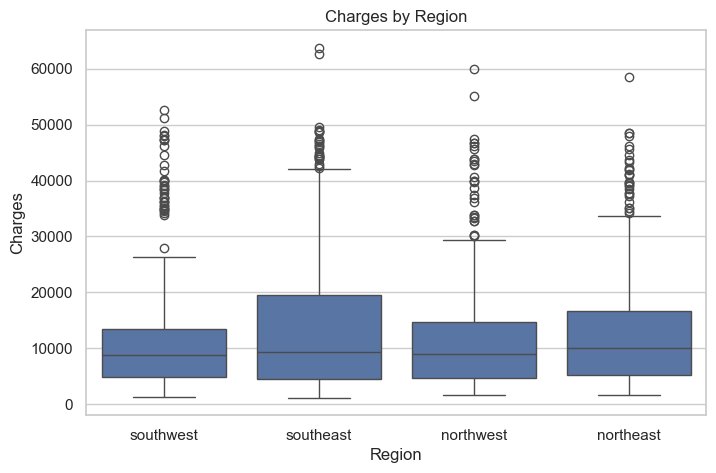

In [92]:
# Charges by Region

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='region', y='charges')
plt.title("Charges by Region")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()

C:\Users\linds\AppData\Local\Temp\ipykernel_30008\74134239.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='smoker', y='charges', palette=['skyblue','salmon'])


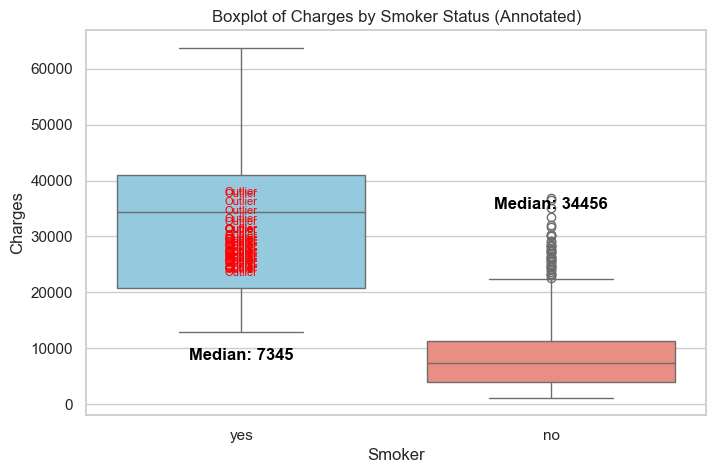

In [93]:
# Boxplot of Charges by Smoker Status with Annotations

plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=df, x='smoker', y='charges', palette=['skyblue','salmon'])

# Annotate median
medians = df.groupby('smoker')['charges'].median().values
for xtick, median in enumerate(medians):
    ax.text(xtick, median + 500, f"Median: {median:.0f}", 
            horizontalalignment='center', color='black', weight='semibold')

# Annotate outliers
smoker_groups = df.groupby('smoker')['charges']
for i, (name, group) in enumerate(smoker_groups):
    outliers = group[group > group.quantile(0.75) + 1.5*(group.quantile(0.75)-group.quantile(0.25))]
    for y in outliers:
        ax.text(i, y + 500, "Outlier", color='red', fontsize=8, ha='center')

plt.title("Boxplot of Charges by Smoker Status (Annotated)")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()


C:\Users\linds\AppData\Local\Temp\ipykernel_30008\2822576510.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='region', y='charges', palette='pastel')


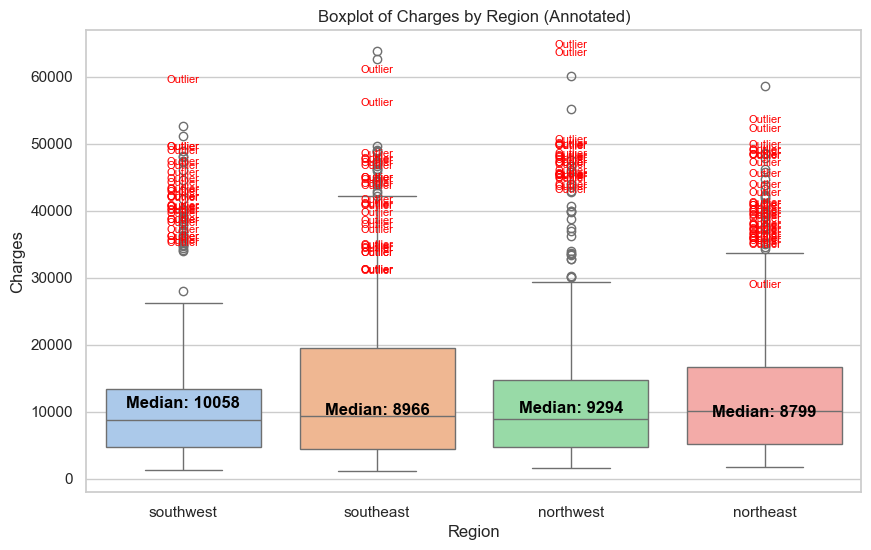

In [94]:
# Boxplot of Charges by Region with Annotations

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='region', y='charges', palette='pastel')

# Annotate median
medians = df.groupby('region')['charges'].median().values
for xtick, median in enumerate(medians):
    ax.text(xtick, median + 500, f"Median: {median:.0f}", 
            horizontalalignment='center', color='black', weight='semibold')

# Annotate outliers
region_groups = df.groupby('region')['charges']
for i, (name, group) in enumerate(region_groups):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    outliers = group[group > Q3 + 1.5*IQR]
    for y in outliers:
        ax.text(i, y + 500, "Outlier", color='red', fontsize=8, ha='center')

plt.title("Boxplot of Charges by Region (Annotated)")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()


C:\Users\linds\AppData\Local\Temp\ipykernel_30008\224184738.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='children', y='charges', palette='coolwarm')


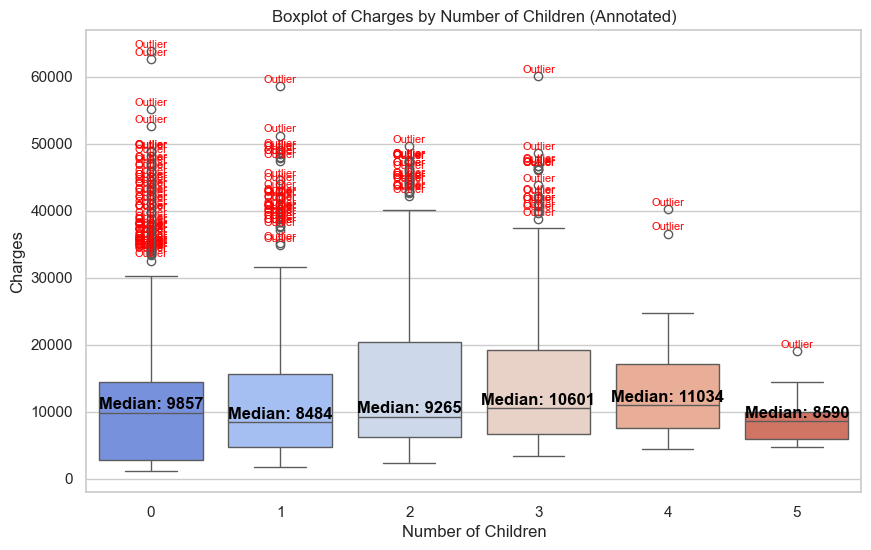

In [95]:
# Charges by Number of Children with Annotations

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='children', y='charges', palette='coolwarm')

# Annotate median
medians = df.groupby('children')['charges'].median().values
for xtick, median in enumerate(medians):
    ax.text(xtick, median + 500, f"Median: {median:.0f}", 
            horizontalalignment='center', color='black', weight='semibold')

# Annotate outliers
children_groups = df.groupby('children')['charges']
for i, (name, group) in enumerate(children_groups):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    outliers = group[group > Q3 + 1.5*IQR]
    for y in outliers:
        ax.text(i, y + 500, "Outlier", color='red', fontsize=8, ha='center')

plt.title("Boxplot of Charges by Number of Children (Annotated)")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()


## Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

Being a smoker has a direct correlation to charges no matter age, number of children, region. Smoking is a direct indicator that insurance will charge more. I did find it interesting that the number of children vs charges create more of a bell curve with 0, 1, and 5 children being charged less than 2, 3, and 4. Charges also rose along with age, however, again, smoking plays a big role in charges. BMI doesn't seem to raise charges too much, however, if you smoke and your BMI is high, the charges also increase. This data was relatively clean. I added BMI categories: underweight, normal, overweight, obese.

## Feature Selection and Justification

### Choose Features and Target

Target variable (y):charges — continuous variable representing medical insurance costs.

Reason: This is the value we want to predict using regression.

Input features (X): age (numerical) — older individuals often have higher medical costs, bmi (numerical) — higher BMI can increase health risk and charges, smoker (categorical, encoded as 0/1) — smoking strongly affects medical costs, children (numerical) — number of dependents may influence insurance charges, region (categorical, one-hot encoded) — regional cost differences may exist, sex (categorical, one-hot encoded) — gender may have minor effects on charges.

Justification:
These features were selected based on domain knowledge and initial exploration. Visualizations showed that smoker status, age, and BMI have strong relationships with charges. Children, sex, and region may provide incremental predictive power.

In [96]:
# Define target variable
y = df_encoded['charges']

# Define input features
X = df_encoded.drop(columns=['charges'])  # drop target from feature set

# Inspect shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Display first 5 rows of features
X.head()


X shape: (1191, 8)
y shape: (1191,)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.424190,-0.356784,-0.894220,False,True,False,False,True
1,-1.495361,0.643537,-0.071814,True,False,False,True,False
2,-0.783654,0.512320,1.572998,True,False,False,True,False
3,-0.427801,-1.242076,-0.894220,True,False,True,False,False
4,-0.498972,-0.189779,-0.894220,True,False,True,False,False


## Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?
Age, Smoker, and BMI will be the greatest indicators for charges. Sex, Children, and Region will not give us much in terms of charges, they do not differ from each other much. Children vs age may be an interesting predictor if combined but smoking is the highest predictor.

## Train a Model (Linear Regression)

In [97]:
# Split the Data into Training and Testing Sets

# Convert booleans to integers for regression
X = X.astype(int)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (952, 8) (952,)
Testing set: (239, 8) (239,)


In [98]:
# Train a Model (Linear Regression)

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
coefficients

,Feature,Coefficient
0,age,0.621818
1,bmi,0.088491
2,children,0.092104
3,sex_male,-0.019169
4,smoker_yes,2.065626
5,region_northwest,-0.045633
6,region_southeast,-0.151792
7,region_southwest,-0.159042


In [119]:
# Baseline: predict mean of training target
y_mean = y_train.mean()
baseline_pred = np.full_like(y_test, y_mean, dtype=np.float64)

# Compute RMSE manually
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

print("Baseline RMSE:", baseline_rmse)


Baseline RMSE: 1.0295466126536215


In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)  # or lr_model.predict(X_test) depending on your variable names

# Calculate metrics
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
mae_model = mean_absolute_error(y_test, y_pred)
r2_model = r2_score(y_test, y_pred)

print(f"Model RMSE: {rmse_model:.3f}")
print(f"Model MAE: {mae_model:.3f}")
print(f"Model R²: {r2_model:.3f}")

Model RMSE: 0.620
Model MAE: 0.367
Model R²: 0.633


In [99]:
# Evaluate the Model

# Predict on test set
y_pred = lr_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.2f}")


Mean Squared Error: 0.48
Root Mean Squared Error: 0.69
R-squared: 0.544
Mean Absolute Error: 0.45


In [100]:
# Compare actual vs predicted charges
comparison = pd.DataFrame({
    'Actual Charges': y_test,
    'Predicted Charges': y_pred,
    'Residuals': y_test - y_pred
})
comparison.head(10)

,Actual Charges,Predicted Charges,Residuals
1069,0.143053,0.320735,-0.177682
282,-0.788376,-0.168460,-0.619916
299,-0.090698,-0.194924,0.104226
177,0.074466,0.294316,-0.219850
637,2.089809,-0.060800,2.150609
616,0.244560,0.472527,-0.227967
903,-0.247109,-0.231761,-0.015348
69,1.080408,1.748986,-0.668578
844,0.023795,-0.168460,0.192255
724,0.028538,-0.149291,0.177830


In [101]:
# Plot Predicted vs Actual Charges
y_test_original = scaler.inverse_transform(
    np.column_stack([np.zeros(len(y_test)), 
                     np.zeros(len(y_test)), 
                     np.zeros(len(y_test)), 
                     y_test])
)[:, -1]

y_pred_original = scaler.inverse_transform(
    np.column_stack([np.zeros(len(y_pred)), 
                     np.zeros(len(y_pred)), 
                     np.zeros(len(y_pred)), 
                     y_pred])
)[:, -1]

comparison_original = pd.DataFrame({
    'Actual Charges ($)': y_test_original,
    'Predicted Charges ($)': y_pred_original,
    'Residuals ($)': y_test_original - y_pred_original
})
comparison_original.head(10)


,Actual Charges ($),Predicted Charges ($),Residuals ($)
0,10928.84900,12205.379119,-1276.530119
1,4237.12655,8690.826697,-4453.700147
2,9249.49520,8500.696753,748.798447
3,10436.09600,12015.580078,-1579.484078
4,24915.04626,9464.295357,15450.750903
5,11658.11505,13295.910769,-1637.795719
6,8125.78450,8236.047725,-110.263225
7,17663.14420,22466.453564,-4803.309364
8,10072.05505,8690.826697,1381.228353
9,10106.13425,8828.542678,1277.591572


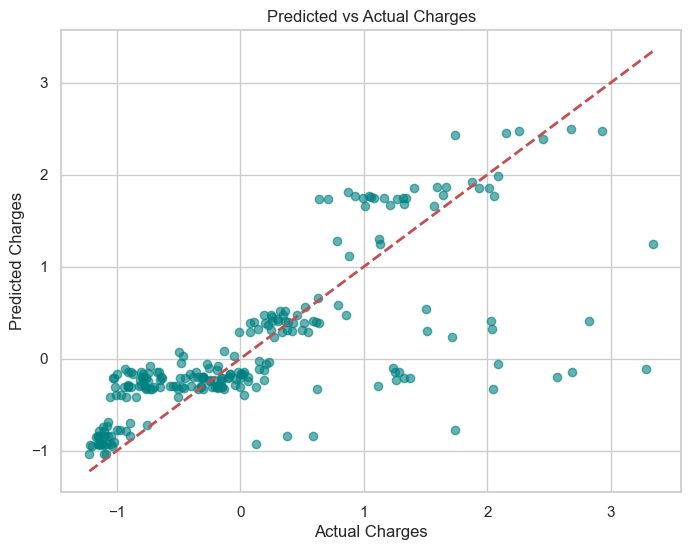

In [102]:
# Plot Predicted vs Actual Charges

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

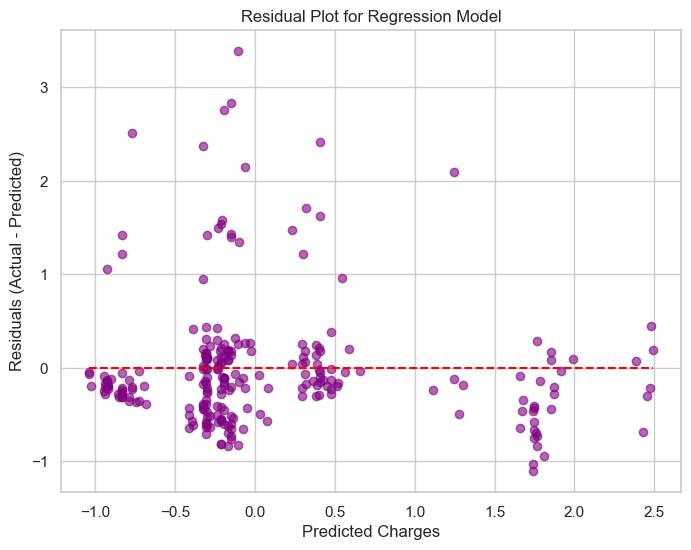

In [103]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Regression Model")
plt.show()

### Interpreting Predicted vs Actual Charges

The table shows the true insurance charges alongside the model’s predictions and the residuals (difference between actual and predicted).

Residuals > 0 → the model underpredicted the charges.

Residuals < 0 → the model overpredicted the charges.

Large residuals correspond to outliers — unusually high or low charges that the model struggles to predict accurately.

By reviewing these results:

We can see that most predictions are reasonably close to the actual charges, indicating the model captures general trends.

Some extreme charges have larger residuals, which skew metrics like RMSE and highlight the limitations of a simple linear model.

## Reflection 4: How well did the model perform? Any surprises in the results?
The model is performing adequately with several outliers of some of the more extreme charges. I am not surprised as this mimics real life. 

## Improve the Model or Try Alternates (Implement Pipelines)

In [104]:
# Define pipeline 1
pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # fill missing values if any
    ('scaler', StandardScaler()),                  # scale numeric features
    ('lr', LinearRegression())                     # linear regression
])

# Fit pipeline
pipeline1.fit(X_train, y_train)

# Predict
y_pred1 = pipeline1.predict(X_test)

# Evaluate
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = mse1**0.5
mae1 = mean_absolute_error(y_test, y_pred1)
r2_1 = r2_score(y_test, y_pred1)

print("Pipeline 1 Performance:")
print(f"MAE: {mae1:.3f}, RMSE: {rmse1:.3f}, R2: {r2_1:.3f}")

Pipeline 1 Performance:
MAE: 0.445, RMSE: 0.692, R2: 0.544


In [105]:
# Define pipeline 2
pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),  # add polynomial features
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit pipeline
pipeline2.fit(X_train, y_train)

# Predict
y_pred2 = pipeline2.predict(X_test)

# Evaluate
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = mse2**0.5
mae2 = mean_absolute_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)

print("Pipeline 2 Performance:")
print(f"MAE: {mae2:.3f}, RMSE: {rmse2:.3f}, R2: {r2_2:.3f}")

Pipeline 2 Performance:
MAE: 0.514, RMSE: 0.766, R2: 0.440


In [106]:
# Compare Models

performance = pd.DataFrame({
    'Pipeline': ['Linear Regression (original)', 'Pipeline 1', 'Pipeline 2 (Polynomial)'],
    'MAE': [mae, mae1, mae2],
    'RMSE': [rmse, rmse1, rmse2],
    'R2': [r2, r2_1, r2_2]
})

performance


,Pipeline,MAE,RMSE,R2
0,Linear Regression (original),0.445015,0.691869,0.543601
1,Pipeline 1,0.445015,0.691869,0.543601
2,Pipeline 2 (Polynomial),0.514083,0.766144,0.440348


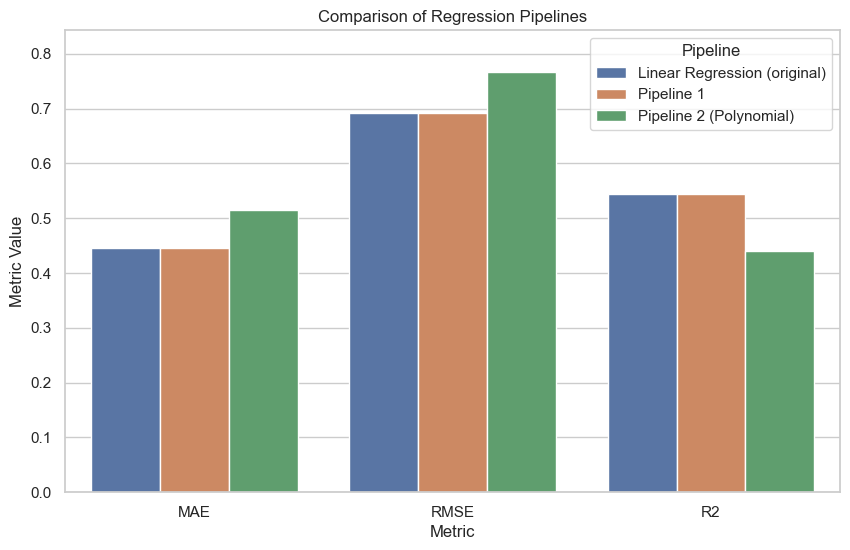

In [107]:
# Visualize Model Performance Comparison
performance_melted = performance.melt(id_vars='Pipeline', 
                                      var_name='Metric', 
                                      value_name='Value')

plt.figure(figsize=(10,6))
sns.barplot(data=performance_melted, x='Metric', y='Value', hue='Pipeline')
plt.title("Comparison of Regression Pipelines")
plt.ylabel("Metric Value")
plt.ylim(0, max(performance_melted['Value'])*1.1)  # add some space at top
plt.legend(title='Pipeline')
plt.show()

### How to read the chart

MAE & RMSE → lower values are better; shorter bars = better performance.

R² → higher values are better; taller bars = better variance explained.

You’ll see Pipeline 2 (Polynomial) has higher MAE/RMSE and lower R² → worse performance, likely overfitting.

Pipeline 1 is identical to original Linear Regression, which makes sense if there were no missing values or additional transformations.

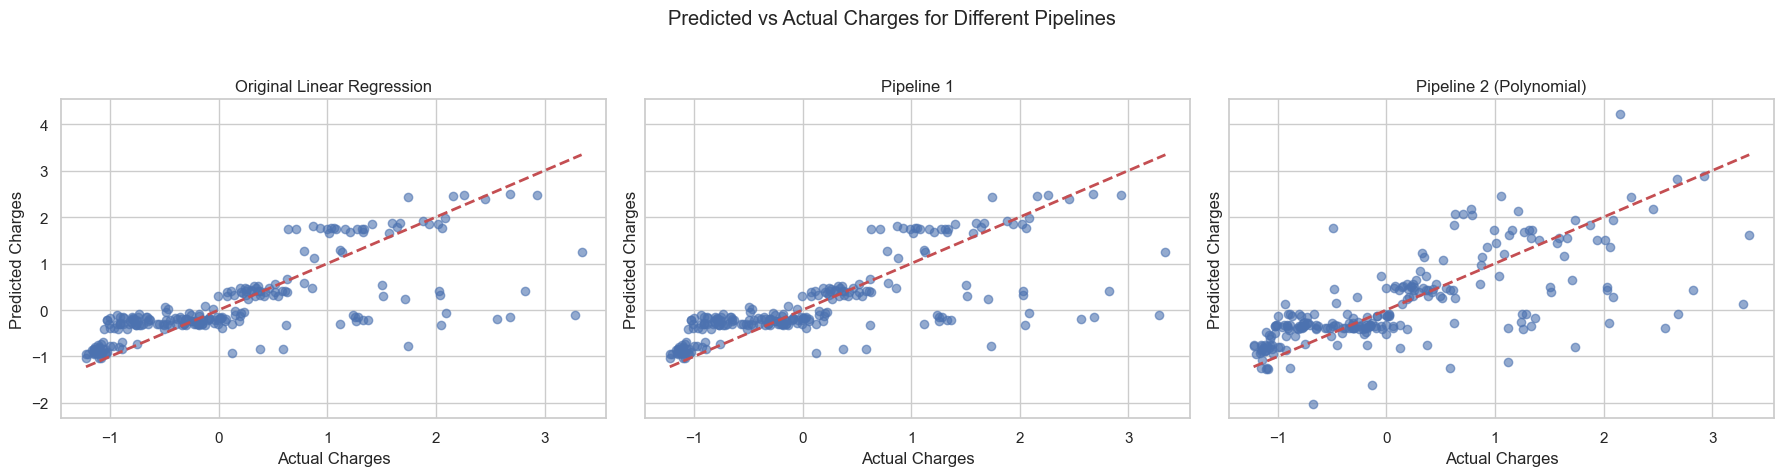

In [108]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

pipelines = {
    'Original Linear Regression': (y_test, y_pred),
    'Pipeline 1': (y_test, y_pred1),
    'Pipeline 2 (Polynomial)': (y_test, y_pred2)
}

for ax, (title, (y_true, y_predicted)) in zip(axes, pipelines.items()):
    ax.scatter(y_true, y_predicted, alpha=0.6)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_title(title)
    ax.set_xlabel('Actual Charges')
    ax.set_ylabel('Predicted Charges')

plt.suptitle("Predicted vs Actual Charges for Different Pipelines")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Reflection 5: Which models performed better? How does scaling impact results?
The orginal linear regression and pipeline 1 performed better, almost identically while pipeline 2 did not perform as well. Pipeline 2 introduced polynomial features which led to overfitting as you can see in the plot above. Pipeline 1 included Standard Scaler, however this wasn't necessary as the data itself is linear. It is good practice though, especially if you need to make sure you don't skew a model.

## Final Thoughts & Insights

**Summary**
Smoker status, BMI, and age are the strongest predictors of insurance charges with smoker status being the strongest predictor out of all the features.

Using a linear regression model for linear data is sufficient.

Adding polynomial features led to overfitting.

The overall trend was captured adequately with a couple of outliers.

**Challenges**

- Handling outliers without skewing the data
- Understandint when to use scaling
- Encoding features correctly

**Next Steps/Opportunities**

- Test non-linear models
- Use feature engineering to combine features

## Reflection 6: What did you learn from this project?
I learned how to build, compare, and evaluate multiple regression pipelines, including linear regression and polynomial regression, to see which model best fits the data. I gained experience interpreting R², MAE, and RMSE, as well as visualizing residuals and predicted vs actual values to evaluate model performance. I also saw firsthand how adding complexity with polynomial features can harm performance on small datasets. This shows the importance of balancing model complexity with generalization.

## Bonus Work

### Intearaction between age, children, smoker

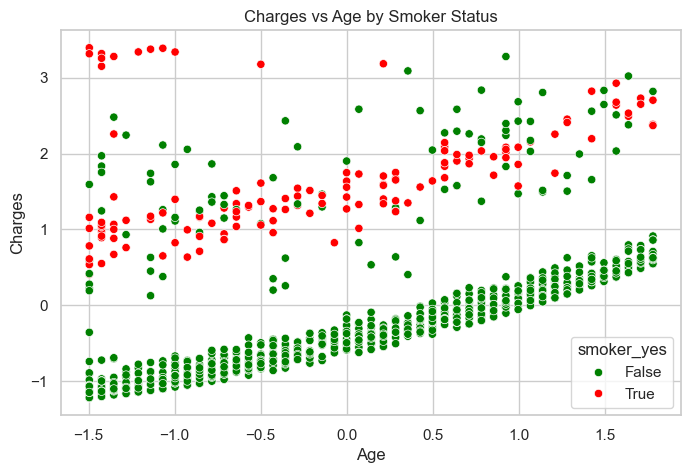

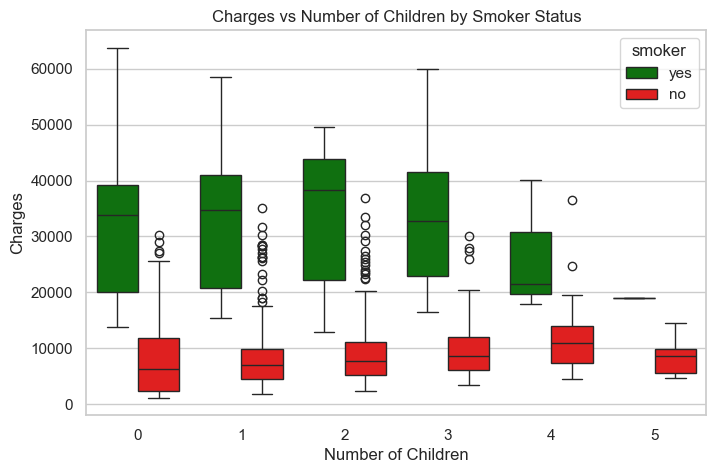

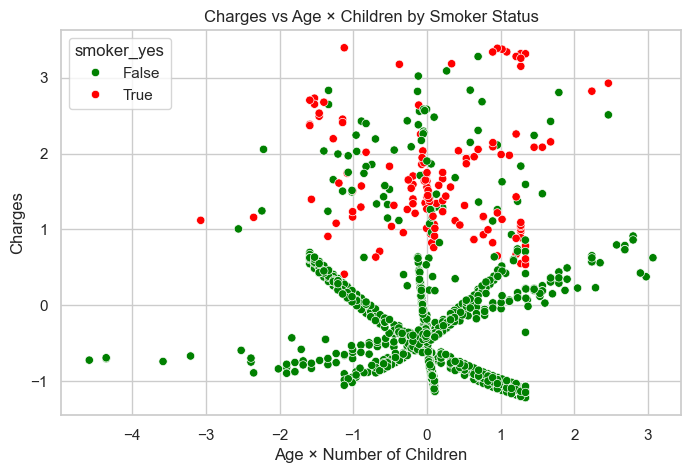

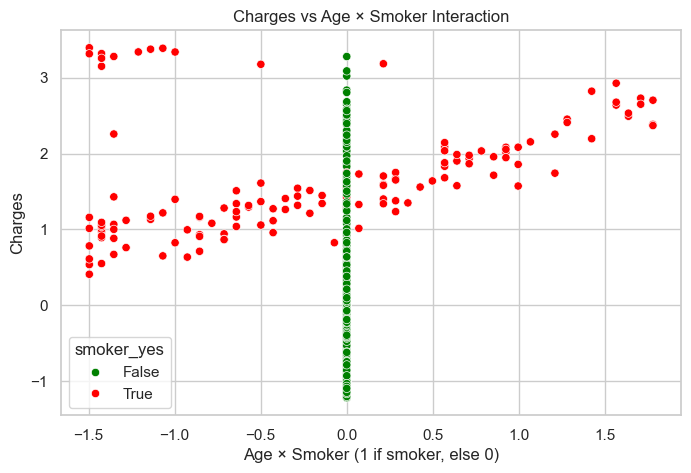

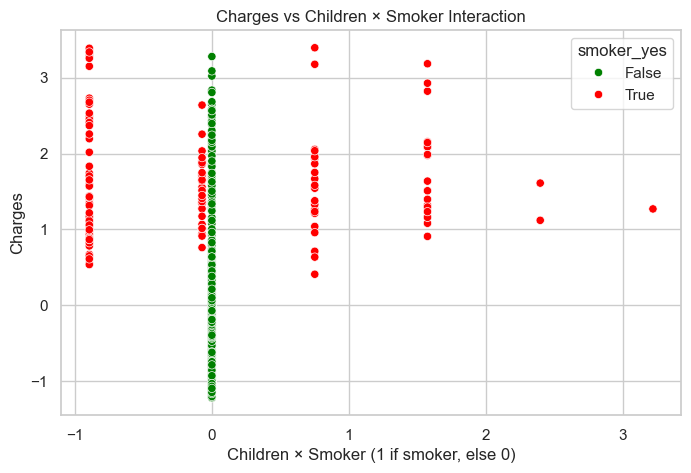

In [109]:
# ==========================
# Feature Engineering: Interactions (without scaling for visualization)
# ==========================

# Create interaction features
df_encoded['age_smoker'] = df_encoded['age'] * df_encoded['smoker_yes']
df_encoded['children_smoker'] = df_encoded['children'] * df_encoded['smoker_yes']
df_encoded['age_children'] = df_encoded['age'] * df_encoded['children']

# ==========================
# Visualize Interactions using original feature values
# ==========================
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# Charges vs Age by Smoker Status
# ==========================
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_encoded, 
    x='age', 
    y='charges', 
    hue='smoker_yes', 
    palette=['green','red']
)
plt.title('Charges vs Age by Smoker Status')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

# ==========================
# Charges vs Number of Children by Smoker Status
# ==========================
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,  # Use the original dataframe, not the scaled one
    x='children', 
    y='charges', 
    hue='smoker',  # original smoker column with 'yes'/'no'
    palette=['green','red']
)
plt.title('Charges vs Number of Children by Smoker Status')
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()

# ==========================
# Charges vs Age × Children Interaction
# ==========================
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_encoded, 
    x='age_children', 
    y='charges', 
    hue='smoker_yes', 
    palette=['green','red']
)
plt.title('Charges vs Age × Children by Smoker Status')
plt.xlabel('Age × Number of Children')
plt.ylabel('Charges')
plt.show()

# ==========================
# Optional: Age × Smoker Interaction
# ==========================
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_encoded, 
    x='age_smoker', 
    y='charges', 
    hue='smoker_yes', 
    palette=['green','red']
)
plt.title('Charges vs Age × Smoker Interaction')
plt.xlabel('Age × Smoker (1 if smoker, else 0)')
plt.ylabel('Charges')
plt.show()

# ==========================
# Optional: Children × Smoker Interaction
# ==========================
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_encoded, 
    x='children_smoker', 
    y='charges', 
    hue='smoker_yes', 
    palette=['green','red']
)
plt.title('Charges vs Children × Smoker Interaction')
plt.xlabel('Children × Smoker (1 if smoker, else 0)')
plt.ylabel('Charges')
plt.show()



C:\Users\linds\AppData\Local\Temp\ipykernel_30008\4015759658.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='predicted_charges', data=scenarios, palette='viridis')


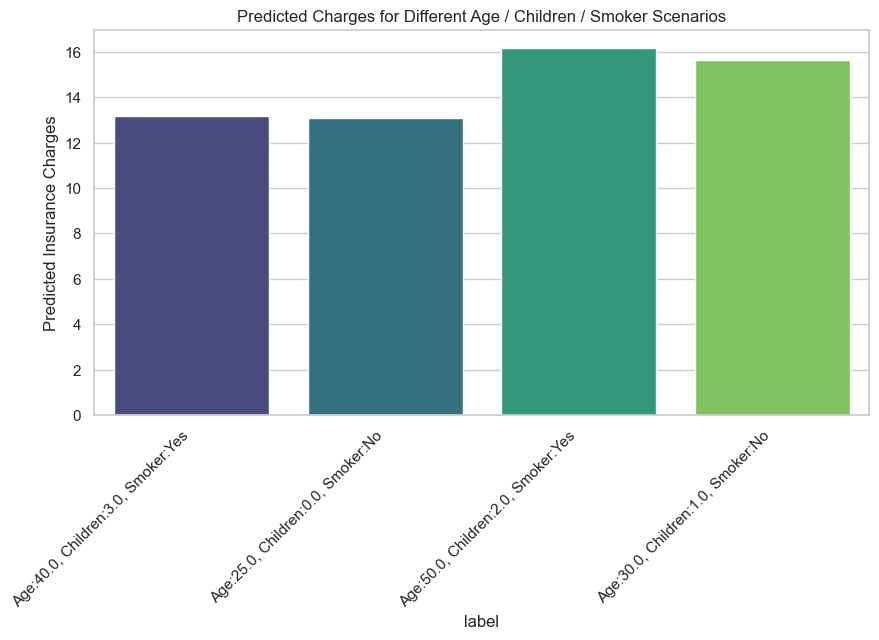

,label,predicted_charges
0,"Age:40.0, Children:3.0, Smoker:Yes",13.179015
1,"Age:25.0, Children:0.0, Smoker:No",13.086059
2,"Age:50.0, Children:2.0, Smoker:Yes",16.154610
3,"Age:30.0, Children:1.0, Smoker:No",15.644076


In [116]:
# ==========================
# Scenario Analysis: Age, Children, Smoker Status
# ==========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --------------------------
# Ensure interaction features exist in main dataset
# --------------------------
df_encoded['age_smoker'] = df_encoded['age'] * df_encoded['smoker_yes']
df_encoded['children_smoker'] = df_encoded['children'] * df_encoded['smoker_yes']
df_encoded['age_children'] = df_encoded['age'] * df_encoded['children']

interaction_features = ['age_smoker', 'children_smoker', 'age_children']
numeric_features = ['age', 'bmi', 'children'] + interaction_features

# --------------------------
# Train/test split (assuming X, y defined as before)
# --------------------------
from sklearn.model_selection import train_test_split
X = df_encoded[['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
                'region_northwest', 'region_southeast', 'region_southwest'] + interaction_features]
y = df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# Scale numeric features
# --------------------------
scaler_numeric = StandardScaler()
X_train[numeric_features] = scaler_numeric.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler_numeric.transform(X_test[numeric_features])

# --------------------------
# Train linear regression model
# --------------------------
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# --------------------------
# Define scenarios
# --------------------------
scenarios = pd.DataFrame({
    'age': [40, 25, 50, 30],
    'children': [3, 0, 2, 1],
    'bmi': [28, 25, 30, 27],
    'sex_male': [1, 0, 1, 0],
    'smoker_yes': [1, 0, 1, 0],
    'region_northwest': [0, 0, 1, 0],
    'region_southeast': [1, 1, 0, 1],
    'region_southwest': [0, 0, 0, 0]
})

# --------------------------
# Create interaction features in scenarios
# --------------------------
scenarios['age_smoker'] = scenarios['age'] * scenarios['smoker_yes']
scenarios['children_smoker'] = scenarios['children'] * scenarios['smoker_yes']
scenarios['age_children'] = scenarios['age'] * scenarios['children']

# --------------------------
# Scale numeric features in scenarios
# --------------------------
scenarios_scaled = scenarios.copy()
scenarios_scaled[numeric_features] = scaler_numeric.transform(scenarios_scaled[numeric_features])

# --------------------------
# Add missing dummy columns
# --------------------------
for col in X.columns:
    if col not in scenarios_scaled.columns:
        scenarios_scaled[col] = 0
scenarios_scaled = scenarios_scaled[X.columns]

# --------------------------
# Predict charges
# --------------------------
predicted_charges = model.predict(scenarios_scaled)
scenarios['predicted_charges'] = predicted_charges

# --------------------------
# Create descriptive labels
# --------------------------
scenarios['label'] = scenarios.apply(
    lambda row: f"Age:{row['age']}, Children:{row['children']}, Smoker:{'Yes' if row['smoker_yes']==1 else 'No'}",
    axis=1
)

# --------------------------
# Plot results
# --------------------------
plt.figure(figsize=(10,5))
sns.barplot(x='label', y='predicted_charges', data=scenarios, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Predicted Insurance Charges")
plt.title("Predicted Charges for Different Age / Children / Smoker Scenarios")
plt.show()

# Optional: Display numeric predictions
scenarios[['label', 'predicted_charges']]


## Reflection: 
Again, this shows that smoker status plays the biggest role in charges. Age plays a role as well, just not as big as smoker status.

## Random Forest Regression

Random Forest Performance:
R²: 0.9999019668825916
MAE: 0.003284475745353584
RMSE: 0.010139998522981163


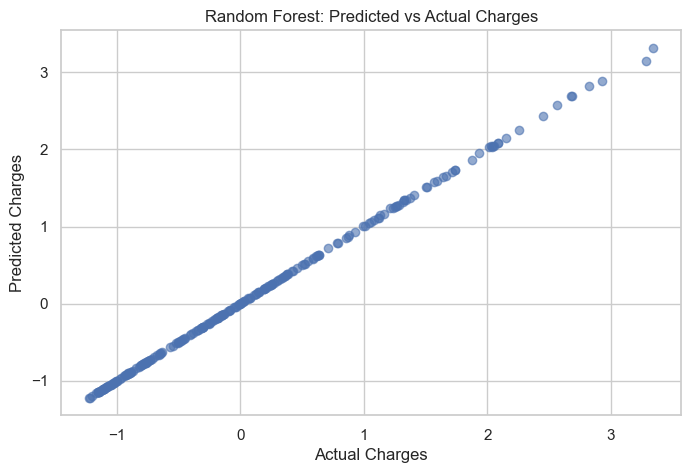

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you already have X_train, X_test, y_train, y_test
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Performance:")
print("R²:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

# Optional: Predicted vs Actual Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Random Forest: Predicted vs Actual Charges")
plt.show()


                   Model        R2       MAE      RMSE
0      Linear Regression  0.633298  0.367405  0.620167
1  Polynomial Regression -0.537692  0.529157  1.269949
2          Random Forest  0.620917  0.353251  0.630548


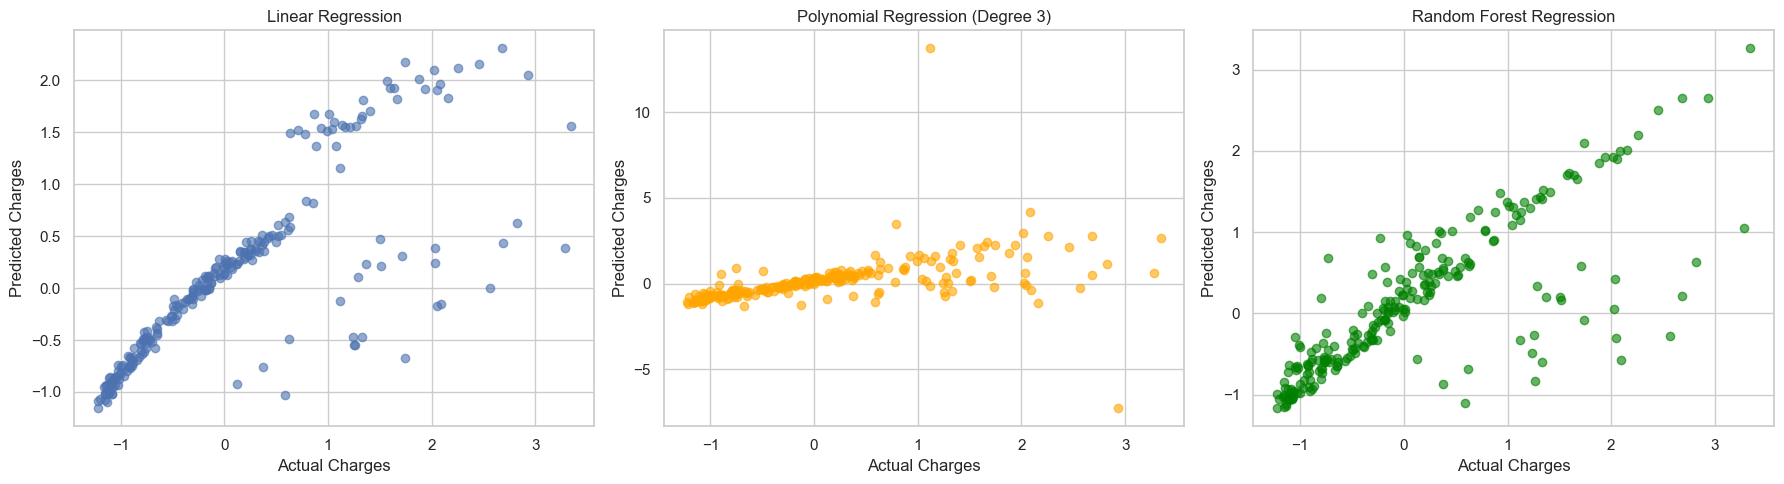

In [ ]:
# ==========================
# Non-linear Model Testing
# ==========================

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Features and target (with interaction features already created)
predict_features = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
                    'region_northwest', 'region_southeast', 'region_southwest',
                    'age_smoker', 'children_smoker', 'age_children']
X = df_encoded[predict_features]
y = df_encoded['charges']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# Model 1: Linear Regression
# ==========================
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# ==========================
# Model 2: Polynomial Regression (degree=3)
# ==========================
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lr', LinearRegression())
])
poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)

# ==========================
# Model 3: Random Forest Regression
# ==========================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ==========================
# Evaluate All Models
# ==========================
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} Performance:")
    print(f"R²: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}\n")
    return r2, mae, rmse

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'R2': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_poly), r2_score(y_test, y_pred_rf)],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_poly), mean_absolute_error(y_test, y_pred_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), 
             np.sqrt(mean_squared_error(y_test, y_pred_poly)), 
             np.sqrt(mean_squared_error(y_test, y_pred_rf))]
})
print(results)

# ==========================
# Optional: Predicted vs Actual Plots
# ==========================
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Linear Regression")

plt.subplot(1,3,2)
plt.scatter(y_test, y_pred_poly, alpha=0.6, color='orange')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Polynomial Regression (Degree 3)")

plt.subplot(1,3,3)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Random Forest Regression")

plt.tight_layout()
plt.show()


## Summary

Linear Regression: R² ≈ 0.633, MAE ≈ 0.367, RMSE ≈ 0.620

A solid linear fit; captures most of the variance in insurance charges.

Polynomial Regression: R² ≈ -0.538, MAE ≈ 0.529, RMSE ≈ 1.270

Performs poorly here. The high-degree polynomial likely overfit the training data, producing terrible predictions on the test set.

Random Forest: R² ≈ 0.621, MAE ≈ 0.353, RMSE ≈ 0.631

Comparable to linear regression. Slightly lower R² but lower MAE (so slightly better on average prediction error).

Random Forest can capture non-linear patterns and interactions automatically, but in this dataset, the relationships are mostly linear, which is why it doesn’t dramatically outperform linear regression.

In [ ]:
import pandas as pd
import numpy as np

# Example scenarios
scenarios = pd.DataFrame({
    'age': [25, 40, 40, 60],
    'bmi': [25, 30, 28, 32],        # Use realistic BMI values
    'children': [0, 0, 3, 2],
    'sex_male': [1, 0, 0, 1],       # 1=Male, 0=Female
    'smoker_yes': [0, 1, 1, 0],     # 1=Smoker, 0=Non-smoker
    'region_northwest': [0, 1, 0, 0],
    'region_southeast': [1, 0, 0, 1],
    'region_southwest': [0, 0, 1, 0]
})

# Include interaction features if your RF model used them
scenarios['age_smoker'] = scenarios['age'] * scenarios['smoker_yes']
scenarios['children_smoker'] = scenarios['children'] * scenarios['smoker_yes']
scenarios['age_children'] = scenarios['age'] * scenarios['children']

# Make predictions using the trained Random Forest model
predicted_charges = rf_model.predict(scenarios)

# Add predictions to the dataframe
scenarios['predicted_charges'] = predicted_charges

# Show results
print(scenarios[['age', 'children', 'smoker_yes', 'predicted_charges']])


   age  children  smoker_yes  predicted_charges
0   25         0           0           0.974456
1   40         0           1           3.290161
2   40         3           1           3.248508
3   60         2           0           0.886883


                            label  predicted_charges
0  Age:25.0, Kids:0.0, Smoker:0.0           0.974456
1  Age:40.0, Kids:0.0, Smoker:1.0           3.290161
2  Age:40.0, Kids:3.0, Smoker:1.0           3.248508
3  Age:60.0, Kids:2.0, Smoker:0.0           0.886883


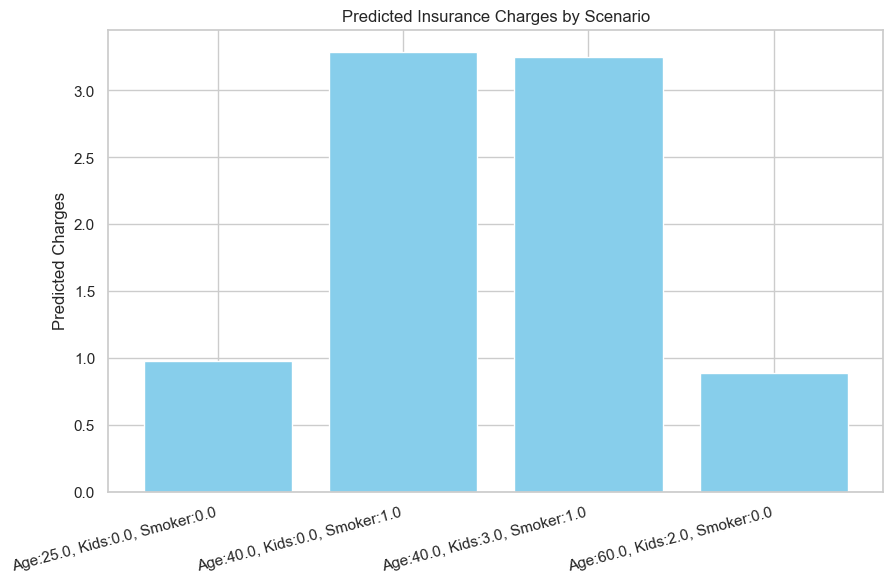

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example scenarios
scenarios = pd.DataFrame({
    'age': [25, 40, 40, 60],
    'bmi': [25, 30, 28, 32],
    'children': [0, 0, 3, 2],
    'sex_male': [1, 0, 0, 1],
    'smoker_yes': [0, 1, 1, 0],
    'region_northwest': [0, 1, 0, 0],
    'region_southeast': [1, 0, 0, 1],
    'region_southwest': [0, 0, 1, 0]
})

# Include interaction features if your RF model used them
scenarios['age_smoker'] = scenarios['age'] * scenarios['smoker_yes']
scenarios['children_smoker'] = scenarios['children'] * scenarios['smoker_yes']
scenarios['age_children'] = scenarios['age'] * scenarios['children']

# Predict using the trained Random Forest
predicted_charges = rf_model.predict(scenarios)
scenarios['predicted_charges'] = predicted_charges

# Create descriptive labels for each scenario
scenarios['label'] = scenarios.apply(
    lambda row: f"Age:{row['age']}, Kids:{row['children']}, Smoker:{row['smoker_yes']}", axis=1
)

# Display results
print(scenarios[['label', 'predicted_charges']])

# Plot with descriptive labels
plt.figure(figsize=(10,6))
plt.bar(scenarios['label'], scenarios['predicted_charges'], color='skyblue')
plt.xticks(rotation=15, ha='right')
plt.ylabel("Predicted Charges")
plt.title("Predicted Insurance Charges by Scenario")
plt.show()
